## Selection of number of filters of filters in convolutional layers

To study the impact of the initial number of filters in the `UNet` model on the model performance and to choose the optimal value. (The subsequent layers have twice the number of filters in relation to the previous layer).

* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a model template](#Creating-a-model-template)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

## The parameters studied

A number of filters in the first convolutional layer: [4, 8, 12].

## Metrics

The average value of the IOU (intersection over union) on the test set, training time and training loss.

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import Dataset, B, V, C, Pipeline
from batchflow.models.tf import UNet
from batchflow.research import Research, Option
from batchflow.research import Results

from src import ShapesBatch, show_research

## Dataset loading

In [1]:
imset = Dataset(1000, ShapesBatch)

## Creating a model template

In [2]:
model_config={'inputs/images/shape': B('image_shape'),
              'inputs/masks/shape': B('image_shape'),
              'initial_block/inputs': 'images',
              'body/filters': C('n_filters'),
              'head/num_classes': 1,
              'loss': 'bce',
              'optimizer': 'Adam',
              'output': ['sigmoid']
             }

Create training and test pipelines

In [3]:
batch_size = 20

train_template = (Pipeline()                 
                  .init_variable('current_loss')
                  .init_model('dynamic', UNet, 'unet', config=model_config)
                  .sample_images(128, max_r=24)
                  .train_model('unet', fetches='loss', images=B('images'), masks=B('masks'),
                               save_to=V('current_loss'))
                  .run_later(batch_size, n_epochs=None))

test_template = (Pipeline()
                 .import_model('unet', C('import_from'))
                 .init_variable('predictions')
                 .init_variable('metrics', init_on_each_run=None)
                 .sample_images(128, max_r=24)
                 .predict_model('unet', fetches='sigmoid', images=B('images'),
                                save_to=V('predictions'))
                 .gather_metrics('segmentation',
                                 targets=B('masks'),
                                 predictions=V('predictions'),
                                 fmt='proba',
                                 save_to=V('metrics', mode='w'))
                 .run_later(batch_size, n_epochs=1))

Setting the parameter value area

In [4]:
base = 2**np.arange(4)
opts = Option('n_filters', [4 * base, 8 * base, 12 * base])

## Creating a research object

Set the parameters for `research` execution:

For each each value `n_filters` in [4, 8, 12] set perform NUM_ITERS=50 iterations of train pipeline with model performance evaluation every 10 iterations. Repeat this procedure NUM_REPEAT=1 times.

In [5]:
research = (Research()
            .add_pipeline(train_template << imset, variables='current_loss', name='train')
            .add_pipeline(test_template << imset, variables='metrics', execute='%10', 
                          name='test', run=True, import_from='train')
            .add_grid(opts))

In [6]:
research.run(n_reps=1, n_iters=50, name='parameters_research', bar=True)

Research parameters_research is starting...


  0%|          | 0/150 [00:00<?, ?it/s]

Distributor has 3 jobs with 50 iterations. Totally: 150


100%|██████████| 150/150 [14:23<00:00,  5.75s/it]


Load `research` results to pandas DataFrame

In [7]:
df = Results(path="parameters_research").load(use_alias=True)
view = df.loc[df['name'] == 'test', 'metrics']
df.loc[df['name'] == 'test', 'metrics'] = view.apply(lambda x: x.evaluate('iou', agg='mean'))

## Results

Loss functions vs a number of iterations for each `n_filters` value:

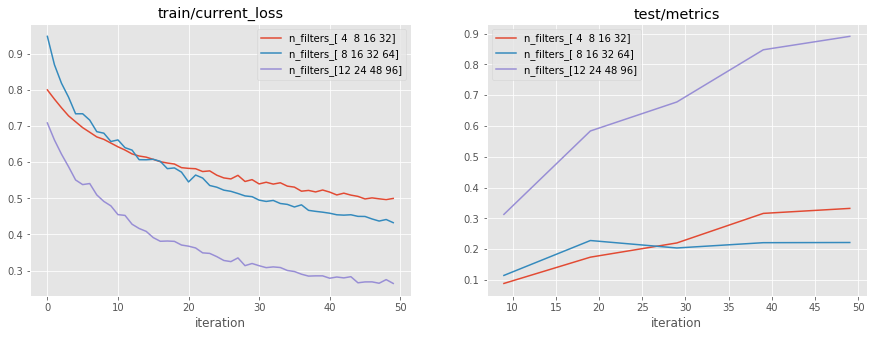

In [8]:
show_research(df, layout=['train/current_loss', 'test/metrics'], average_repetitions=True)

It can be concluded that `n_filters` = 12 achives better performance in fewer number of iterations.

## Conclusion

Model with larger number of filters achives better performance. Among given parameter values the best is n_filters = 12